# Using Nilearn for analysis of faceWord data in BIDS format

This tutorial is almost identical to tutorial 09 and is based on [this analysis](https://nilearn.github.io/stable/auto_examples/07_advanced/plot_bids_analysis.html).
 and [this analysis](https://nilearn.github.io/dev/auto_examples/00_tutorials/plot_single_subject_single_run.html#sphx-glr-auto-examples-00-tutorials-plot-single-subject-single-run-py) presented on the Nilearn web-page.


# BIDS dataset first and second level analysis


This tutorial contains step-by-step example of fitting a `GLM` to perform a first (single subject) and second level (group)
analysis in a `BIDS` dataset and visualizing the results.

#### Brain Imaging Data Structure (BIDS)
`BIDS`is a particular convention for storing neuroimaging data, which makes it easier to reproduce and share analyses:

![img](https://media.springernature.com/m685/springer-static/image/art%3A10.1038%2Fsdata.2016.44/MediaObjects/41597_2016_Article_BFsdata201644_Fig1_HTML.jpg)

Details about the `BIDS` standard can be consulted at
[http://bids.neuroimaging.io](http://bids.neuroimaging.io/).



## In this tutorial, we will:

1. Download an fMRI `BIDS` dataset with two language conditions to contrast (reading sentences and letter strings).
2. Extract first level (single subject) model objects automatically from the `BIDS` dataset.
3. Investigate the model and plot it design matrix, contrasts and effects.
4. Fit a second level (group) model on the fitted first level models. Notice that
   in this case the preprocessed `BOLD` images were already normalized to the
   same `MNI` space.
5. Plot the results in different ways to show some of the possibilities in Nilearn.


In [ ]:
# import some functionality
from datetime import datetime

now = datetime.now()
print('Starting cell:',now.strftime("%H:%M:%S"))
import os
import pip
os.system('python -m pip install numpy')
os.system('python -m pip install matplotlib')
os.system('python -m pip install scipy')
os.system('python -m pip install panda')
os.system('python -m pip install nilearn')
os.system('python -m pip install pickle')
os.system('python -m pip install atlasreader')

#import os.path as op
#import numpy as np
#from numpy.linalg import inv
#import nibabel as nib
import matplotlib.pyplot as plt
#from scipy.ndimage import gaussian_filter

%matplotlib inline

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

## Fetch faceWord BIDS dataset
The faceWord dataset is located in the `fMRI_data_raw` folder.



### Investigating the BIDS structure
Let's make a function to see what this folder contains.

In [ ]:
def list_files(startpath):
    """ Simple function to show directory tree. 
    From: https://stackoverflow.com/questions/9727673/list-directory-tree-structure-in-python. """
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in sorted(files):
            print('{}{}'.format(subindent, f))
            
data_dir='/work/82777/BIDS/' 
derivatives_dir=  '/work/82777/BIDS/derivatives/'          
list_files(derivatives_dir)

### What is in the BIDS folder?
This `BIDS` dataset folder contains different mandatory elements ([http://bids.neuroimaging.io](http://bids.neuroimaging.io/)). These include:
- A folder for each participant, e.g. `sub-01`. This contains a subfolder called `func` where the raw BOLD data is usually stored along with a `.tsv` file describing the events (experimental design) of the particular scan. In this dataset the raw data has been left out. Also the `anat`folder, which normally contains anatomical scans have been left out.
- A folder called `derivatives` which is used to store processed data. In this dataset, we will can find preprocessed data files `preproc_bold.nii` and the `confounds_regressors.tsv` files (which contains the motion parameters from the spatial realignment. 
- A number of `.json` files with meta-data.

NB. All the filenames contain a description of the particular experiment.

## Obtain automatically FirstLevelModel objects and fit arguments
From the dataset directory we automatically obtain the FirstLevelModel objects
with their subject_id filled from the :term:`BIDS` dataset. Moreover, we obtain
for each model a dictionary with run_imgs, events and confounder regressors
since in this case a confounds.tsv file is available in the :term:`BIDS` dataset.
To get the first level models we only have to specify the dataset directory
and the task_label (`languagelocalizer`) as specified in the file names.



In [ ]:
from nilearn.glm.first_level import first_level_from_bids

#BIDS directory
data_dir='/work/82777/BIDS/'
# BIDS derivatives (contains preprocessed data)
derivatives_dir='/work/82777/BIDS/derivatives' 
# Name for experiment in the BIDS directory
task_label = 'EPIsequencewords'
# Label for data that are spatially aligned to the MNI152 template (i.e. spatially normalised)
space_label ='MNI152NLin2009cAsym'
#Run the function that can gather all the needed info from a BIDS folder
models, models_run_imgs, models_events, models_confounds = \
    first_level_from_bids(
        data_dir, task_label, derivatives_folder=derivatives_dir, n_jobs=6, verbose=1,
        img_filters=[('desc', 'preproc')])

#Print the data from the first participant as sanity check
print(models_run_imgs[0])

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

### What just happened?
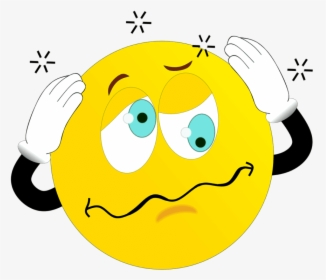

The above code looks somewhat opaque. What is happening here? Let's look into the `first_level_from_bids` function.

In [ ]:
#What does the `first_level_from_bid` function take as arguments?
import inspect
import pandas as pd
#Get the argument from the function
args=inspect.getfullargspec(first_level_from_bids)

#Make a dataframe to display arguments (skip the first two ('dataset_path' and 'task_label') that have no defaults
df = pd.DataFrame(args.defaults,args.args[2:])
print(df)

#Same info can also be obtained by writing first_level_from_bids?

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

Here, we can see that the function uses information about `t_r` (TR), `HRF_model` (hemodynamic response function),``drift_model`` and `high_pass` (both used for high-pass filtering), `noise_model`(used for modelling auto correlation). In other words, this function seems to implement all the elements, we have been going through in previous tutorials.

<b>Nice stuff!</b>

## Quick sanity check on fit arguments
Additional checks or information extraction from pre-processed data can
be made here.



As, we have seen from the folder inspection, we only have one run_img per subject.



In [ ]:
import os
#Get the file names for subj01 functional data
func01=([os.path.basename(run) for run in models_run_imgs[12]])
print(func01)



Let's load this file and inspect the data.

In [ ]:
from nilearn import image

#Get the full path
func01_path=([os.path.abspath(run) for run in models_run_imgs[0]])
#Load the image and inspect data size
func_img = image.load_img(func01_path)
print("Shape of functional MRI image: %s" % (func_img.shape,))

As we see, the data contains 6x600 = 3600 volumes with a 78 x 92 x65 voxel resolution.

In [ ]:
print(models[0])

Here, we see that the model is a `FirstLevelModel` object ([See here for details](https://nilearn.github.io/dev/modules/generated/nilearn.glm.first_level.FirstLevelModel.html)). This means that it incorporates all the same default values for setting up and estimating GLM-fMRI models as in the `first_level_from_bids`, unless else is mentioned. 

Here, we see the additional information that data were obtained with a TR of 1.0 seconds.

fmriprep exports a large number of [confounding parameters](https://fmriprep.org/en/stable/outputs.html#confounds) which can be used to regress out noise in the data. These are saved in a .tsv file in the derivatives folder (func) with the name `sub-00xx_task-EPIsequencewords_run-1_desc-confounds_timeseries.tsv`.

These are automatically imported into the `model_confounds` variable.
Let's inspect what we find in the `models_confounds` variable.

In [ ]:
#Print model confounds for first participant, first run
print(models_confounds[0][0].columns)



There are literally hundreds of confounds stored.
Read more about them [here](https://fmriprep.org/en/stable/outputs.html#confounds)

Read more about how they can be used in [this article](https://www.sciencedirect.com/science/article/pii/S1053811917310972?via%3Dihub)
Here, we will pick the Friston24 confound variables. These correspond to the rotations and translations, we covered in the <tt>08_fMRI_preprocessing2_spatial.ipyn</tt> tutorial in combination with their derivatives and their squares. We will combine them with four measures of the global signal.

In [ ]:

confound_friston24 = ['trans_x','trans_y','trans_z',
                 'rot_x','rot_y','rot_z','trans_x_derivative1','trans_y_derivative1','trans_z_derivative1',
                 'rot_x_derivative1','rot_y_derivative1','rot_z_derivative1','trans_x_power2','trans_y_power2','trans_z_power2',
                 'rot_x_power2','rot_y_power2','rot_z_power2']

confound_friston24_GSR = ['global_signal','global_signal_derivative1','global_signal_power2','global_signal_derivative1_power2','trans_x','trans_y','trans_z',
                 'rot_x','rot_y','rot_z','trans_x_derivative1','trans_y_derivative1','trans_z_derivative1',
                 'rot_x_derivative1','rot_y_derivative1','rot_z_derivative1','trans_x_power2','trans_y_power2','trans_z_power2',
                 'rot_x_power2','rot_y_power2','rot_z_power2']

# Subset confounds with selection
for ii in range(len(models_confounds)):
    confounds1=models_confounds[ii][:].copy()
    for i in range(len(confounds1)):
        confounds2=confounds1[i].copy()
        confounds2=confounds2[confound_friston24_GSR]
        #Removing NAs in the first row.
        confounds2.loc[0,:]=confounds2.loc[1,:]
        confounds1[i]=confounds2
    models_confounds[ii][:]=confounds1


#Print new confounds, for first participant, first run
print(models_confounds[0][0].columns)

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

### Events from the experiment
Next, we will see what is in the `models_events` variable.

In [ ]:
print(models_events[0][0])

We will trim this a bit as well, to avoid some annoying error messages

In [ ]:
#Print model confounds for first participant, first run
print(models_events[0][0].columns)

events_sub= ['onset','duration','trial_type']



# Subset confounds with selection
for ii in range(len(models_events)):
    events1=models_events[ii][:]
    for i in range(len(events1)):
        events2=events1[i]
        events2=events2[events_sub]
        events1[i]=events2
    models_events[ii][:]=events1


#Print new confounds, for first participant, first run
print(models_events[0][0].columns)

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))



We can see check how many trials were in each condition:

In [ ]:
print(models_events[0][0]['trial_type'].value_counts())

60 trials!

## First level (single subject) model estimation
Now, that we have seen that the `first_level_from_bids` function gathers everything we need for analysis, we can get going with the analysis


### Analysing one participant

We will start by analysing the data from the first participant and generating a report of the process and the results.

If we have a [`FirstLevelModel`](https://nilearn.github.io/dev/modules/generated/nilearn.glm.first_level.FirstLevelModel.html) class object as we have created above, we can use the variable.fit() function to pair the `FirstLevelModel`object with the missing information (e.g. functional images, events and a matrix of confounding variables), assemble the model and estimate it.

In [ ]:

# Get data and model info for 1st participant
model1=models[0]
imgs1=models_run_imgs[0]
events1=models_events[0]
confounds1=models_confounds[0]

#Fit the model
model1.fit(imgs1,events1,confounds1)
model1.zmap=model1.compute_contrast('image_neg-image_pos')

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

### Plotting the design matrix
We will then use the `plot_design_matrix`function to give the model a sanity check. 

In [ ]:

from nilearn.plotting import plot_design_matrix

# View the design matrix
design_matrix = model1.design_matrices_[0]


#Plot the design matrix
plot_design_matrix(design_matrix)
plt.show()

# Also plot time series
plt.plot(design_matrix['image_pos'])
plt.xlabel('scan')
plt.title('Expected Response from image_pos condition')
plt.show()

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

We see that the design matrix contains 2 columns for the conditions + 6 for the motion parameters + 6 cosine functions for high-pass filtering + one constant/intercept.

When plotting the expected response function, we see that it looks like the hemodynamic response function.


### Defining contrasts


Next, we need to specify the `contrasts` that we are interested in. These can be defined using using vectors or the names of of the conditions, specified in the events dataframe. Sum, subtraction and scalar multiplication are allowed.


In [ ]:
from nilearn.plotting import plot_contrast_matrix

#Define contrasts
contrasts=['image_pos','image_neg','image_pos+image_neg','image_neg-image_pos']

# Plot them to see what they look like
for contrast in contrasts:
    plot_contrast_matrix(contrast, design_matrix=design_matrix)
    
now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

### Setting the significance threshold
To display the results, we will set a statistical threshold. Conventionally p<0.001, uncorrected for multiple comparisons has been used. 

It often gives a good picture of what is at play in the data, but should be interpreted with caution, due to the fact that it is uncorrected.

In [ ]:
from scipy.stats import norm
p001_unc = norm.isf(0.001)

### Plotting the results
Now, we will plot the results from the different contrasts. We will do so using the mean of the functional data as background.

In [ ]:
from nilearn.plotting import plot_stat_map
from nilearn.reporting import get_clusters_table
from nilearn.image import mean_img


# Make a mean image for display purposes
mean_img_ = mean_img(imgs1)

for contrast in contrasts:
    z_map = model1.compute_contrast(contrast, output_type='z_score')


    titlex=''.join([contrast, ' ', '(p<0.001, uncor.)'])
    plot_stat_map(z_map, bg_img=mean_img_, threshold=p001_unc,
              display_mode='z',  black_bg=True,
              title=titlex)
    plt.show()
    
    # Make a table of cluster coordinates.
    table = get_clusters_table(z_map, stat_threshold=p001_unc,
                           cluster_threshold=20)
    print(table)
    
now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

### Make a report of the results

We can also use the [`make_glm_report`](https://nistats.github.io/modules/generated/nistats.reporting.make_glm_report.html) function to make a report in one go. This report is generated as a HTML document, which can only be viewed in a notebook.

This also includes a table of cluster coordinates.


In [ ]:
from nilearn.reporting import make_glm_report
#Generate a report
report = make_glm_report(model1,
                         contrasts=contrasts,
                         threshold=p001_unc,
                         bg_img=mean_img_,
                         )
#Display report in HTML format
report

### Making an F contrast


In [ ]:
import numpy as np

#create a contrast matrix for the F-contrast, spanning the two first columns in the design matrix
effects_of_interest =np.identity(design_matrix.shape[1])[[0,1],:]

#Let's see what it looks like
plot_contrast_matrix(effects_of_interest, design_matrix)
plt.show()

#Similar to above, we will compute the effect
z_map = model1.compute_contrast(effects_of_interest,
                                  output_type='z_score')

#And plot the results using an overlay
plot_stat_map(z_map, bg_img=mean_img_, threshold=p001_unc, cmap='autumn',
              display_mode='z',  black_bg=True,cut_coords=[-30,-20,-10,0,10,20,30],
              title='F-contrast: (p<0.001, uncor.)')
plt.show()
    
# Make a table of cluster coordinates.
table = get_clusters_table(z_map, stat_threshold=p001_unc,
                           cluster_threshold=20)
print(table)

### Analysing all single participants in one go and plotting them

Now, we will make a loop which fits all the models and plots the results. We will focus on the `image_neg-image_pos` contrast.



In [ ]:
from nilearn import plotting
import matplotlib.pyplot as plt

now = datetime.now()
print('Starting cell:',now.strftime("%H:%M:%S"))

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 20)) 
model_and_args = zip(models, models_run_imgs, models_events, models_confounds)
for m_idx, (model, imgs, events, confounds) in enumerate(model_and_args):
    # fit the GLM, recall that the model variable is a FirstLevelModel object
    model.fit(imgs, events, confounds)
    # compute the contrast of interest and make a map of z-values
    model.zmap = model.compute_contrast('image_neg-image_pos')
    #Plot each thresholded analysis
    plotting.plot_glass_brain(model.zmap, cmap='jet',colorbar=True, threshold=p001_unc,
                              title=('sub-' + model.subject_label),
                              axes=axes[int(m_idx / 5), int(m_idx % 5)],
                              plot_abs=False, display_mode='x')

   
fig.suptitle('subjects z_map image diff (unc p<0.001)')
plotting.show()

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

#### Same but different
Note that the single subject results look very different, although one can also see patterns in most participants that look similar.

## Saving results.

The analysis took a bit of time. Let's make sure to save the results, so that we don't have to run that again. 

#### Remember to change the directory to somewhere convenient.

In [ ]:
import pickle

#Save the first level models

# Saving the objects:
f = open('/work/MikkelWallentin#6287/WordFace_first_level_models.pkl', 'wb')
pickle.dump([models, models_run_imgs, models_events, models_confounds], f)
f.close()

# Getting back the objects:
#f = open('store.pckl', 'rb')
#models, models_run_imgs, models_events, models_confounds = pickle.load(f)
#f.close()

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

## Second level (group) model estimation

To investigate the degree of overlap in the data, we will perform a 2nd level analysis, where the contrast estimates for each individual participant will enter as data in a new statistical test.

We just have to provide the list of fitted FirstLevelModel objects
to the SecondLevelModel object for estimation. We can do this because
all subjects share a similar design matrix (same variables reflected in
column names).



In [ ]:
from nilearn.glm.second_level import SecondLevelModel
#We will simply add the models estimated above to the second level

#second_level_input = models

#NB idx11 has different resolution for some reason
second_level_input = models[0:11]+models[12:]

#Adding the smoothing parameter
second_level_model = SecondLevelModel(smoothing_fwhm=8.0)
second_level_model = second_level_model.fit(second_level_input)

print(second_level_model)

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

Note that we apply a smoothing of 8mm.



Computing contrasts at the second level is as simple as at the first level.
Since we are not providing confounders we are performing a one-sample test
at the second level with the images determined by the specified first level
contrast.



In [ ]:
# NB, variable names used in contrasts have to be the same as those in events file.
zmap_g = second_level_model.compute_contrast(
    first_level_contrast='image_neg-image_pos')

The group level contrast shows...


In [ ]:
from nilearn.plotting import plot_stat_map
import matplotlib

plotting.plot_glass_brain(zmap_g, cmap='PiYG',colorbar=True, threshold=None,
                          title='Group [image_neg-image_pos] effect (unthresholded)',
                          plot_abs=False)
plt.show()

plot_stat_map(zmap_g, cmap='cold_hot',threshold=p001_unc, cut_coords=[-30,-20,-10,0,10,20,30],
              display_mode='z',  black_bg=False,
              title='Group [image_neg-image_pos] effect (unc p<0.001)')
plt.show()

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

In [ ]:
from nilearn.glm import threshold_stats_img

thresholded_map, threshold = threshold_stats_img(
    zmap_g, alpha=0.05, height_control='bonferroni')
print('The p<.05 FWER-corrected threshold is %.3g' % threshold)

plotting.plot_glass_brain(zmap_g, cmap='PiYG',colorbar=True, threshold=threshold,
                          title='Group [image_neg-image_pos] effect (p<0.05,Bonferroni-corrected)',
                          plot_abs=False)
plt.show()

# Make a table of cluster coordinates.
table = get_clusters_table(zmap_g, stat_threshold=threshold)
print(table)

### Find anatomical labels for peak activations
We will use a function called [atlasreader](https://github.com/miykael/atlasreader).

In [ ]:
from atlasreader import create_output
create_output(zmap_g, voxel_thresh=threshold, cluster_extent=0,direction='both')
#Atlasreader automatically saves results to both .png-files and a csv-file. Look in your working directory.
pd.read_csv('atlasreader_peaks.csv')

As can be seen, the fdr correction may be too lenient, and the FWE correction may be too stringent.

## Non-parametric permutation methods for calculating corrected p-values

Based on [this](https://nilearn.github.io/dev/auto_examples/05_glm_second_level/plot_second_level_one_sample_test.html#sphx-glr-auto-examples-05-glm-second-level-plot-second-level-one-sample-test-py) example.

Permutation tests are a class of non-parametric methods. They were pioneered by Fisher (1935) and Pitman (1937). Fisher demonstrated that the null hypothesis could be tested simply by observing, after permuting observations, how often the difference between means would exceed the difference found without permutation, and that for such test, no normality would be required.


![permutation_stats.jpg](images/permutation_stats.jpg)

If we are comparing two samples (e.g. `treatment` and `control`), we can calculate the effect, we get when shuffling the category labels.

![Permutation_test_example_animation.gif](images/Permutation_test_example_animation.gif)
Source:[Wikipedia](https://en.wikipedia.org/wiki/Permutation_test)

The percentage of values we get that are bigger than our original value, represents the probability that our value comes from the null-distribution.

The one-sided p-value of the test is calculated as the proportion of sampled permutations where the difference in means was greater than ${\displaystyle T_{\text{obs}}}$. 
The two-sided p-value of the test is calculated as the proportion of sampled permutations where the absolute difference was greater than 
${\displaystyle |T_{\text{obs}}|}$.

When conducting a one-sample group analysis with fMRI-data, we are testing ${\displaystyle H_{0}:T=0}$, i.e.  if the effect of any given voxel is larger than zero. We can obtain a null-distribution by estimating the effect N times, while randomly flipping the sign on each datapoint.

### Making a an image for comparison
Before we make the permutation test, we'll calculate an image from the parametric analysis for comparison. We will use the negative log of the p-value as a measure.


In [ ]:
import numpy as np
from nilearn.image import get_data, math_img

#Get an image of p-values
p_val = second_level_model.compute_contrast(first_level_contrast='image_neg-image_pos',output_type='p_value')
# Get the number of voxels in the image
n_voxels = np.sum(get_data(second_level_model.masker_.mask_img_))
# Making an image with significant values, correcting the p-values for multiple testing and taking negative logarithm
neg_log_pval = math_img(
    '-np.log10(np.minimum(1, img * {}))'.format(str(n_voxels)),
    img=p_val,
)

#Check image shape
print(neg_log_pval.shape)

### Next, we perform the permutations.

In [ ]:
from nilearn.glm.second_level import non_parametric_inference

now = datetime.now()
print('Starting cell:',now.strftime("%H:%M:%S"))

# n_perm=1000 for the sake of time. Ideally, this should be 10,000, but the upper limit on permutations is 2 to the power of N.
n_perm=10000

#We base the analysis on a contrast image (z-score map) from each participant
second_level_input2=[]
#Put the NIimg zmaps into a list.
for ii in range(21):
    second_level_input2.append(second_level_input[ii].zmap)

design_matrix = pd.DataFrame(
    [1] * len(second_level_input2),
    columns=['intercept'],
)
print(design_matrix)

#Calculate p-values using permutation
out_dict = non_parametric_inference(
    second_level_input2,
    design_matrix=design_matrix,,
    model_intercept=True,
    n_perm=n_perm,  
    two_sided_test=False,
    smoothing_fwhm=8.0,
    n_jobs=1,
        
    
)

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

Now let's plot the permutation results and compare with the bonferroni corrected effect. 

Note that effects are now negative log of the p-value, so we will have to take that into consideration when plotting.

In [ ]:

# Prepare thresholds for plotting

threshold_log = round(-np.log10(1 / 20))  # p < 0.05 
vmax = round(-np.log10(1 / n_perm)) # minimal p-value possible with the number of permuations

cut_coords = [0]

#Prepare images to plot
IMAGES = [
    neg_log_pval,
    out_dict
]
TITLES = [
    'Parametric Test',
    'Permutation Test\n(Voxel-Level Error Control)',
]

#Make loop with plots
fig, axes = plt.subplots(figsize=(8, 8), nrows=2, ncols=1)
img_counter = 0
i_row=0
for j_row in range(2):
        ax = axes[j_row]     
        plotting.plot_glass_brain(
            IMAGES[img_counter],
            colorbar=True,
            vmax=vmax,
            plot_abs=False,
            cut_coords=cut_coords,
            threshold=threshold_log,
            figure=fig,
            axes=ax,
        )

        
        ax.set_title(TITLES[img_counter])
        img_counter += 1


fig.suptitle('Group [image_neg-image_pos] contrast\n(negative log10 p-values)')
plt.show()

### Publish!!!

We have a result. We are almost ready for publication. All we need to know is what it means... 

In [ ]:
now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))